<a href="https://colab.research.google.com/github/Bangkit-Capstone-C241-BB01/BlurOrBokeh_ML_All/blob/main/Hand_Designed_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import PIL
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Concatenate, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model

PIL.Image.MAX_IMAGE_PIXELS = None

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_size = (300, 300)
class_names = ["Blur", "Bokeh", "Normal"]

train_dir = os.path.join(data_dir, "train")
validation_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [ ]:
base_dir = "/content/drive/My Drive/Blur or Bokeh/DatasetV4"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=5,
    class_mode="sparse"
)

In [ ]:
base_dir = "/content/drive/My Drive/Blur or Bokeh"

data_dir = os.path.join(base_dir, "DatasetV4")
serialized_data_dir = os.path.join(base_dir, "Serialized Data")
library_dir = os.path.join(base_dir, "Library")

sys.path.append(library_dir)
from utils import FeatureExtractor
from cf_matrix import make_confusion_matrix

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
model = hub.load(module_handle)
model.signatures.keys()
detector = model.signatures["default"]

In [ ]:
X_train = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_train_pre.npy")))
y_train = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "y_train.npy")))
X_val = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_val_pre.npy")))
y_val = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "y_val.npy")))
X_test = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_test.npy")))
y_test = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "y_test.npy")))
X_test_pre = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_test_pre.npy")))

In [ ]:
indices = tf.where(y_train == 2)
hd_images_pre = tf.gather(X_train_pre, indices)

In [ ]:
tf.reduce_max(X_train_pre)

<tf.Tensor: shape=(), dtype=float32, numpy=0.12300942>

In [ ]:
X_train

<tf.Tensor: shape=(1771, 2), dtype=float32, numpy=
array([[  82.110245,  243.95938 ],
       [  10.693876,    0.      ],
       [ 999.905   , 1569.7417  ],
       ...,
       [ 505.43842 , 1265.8358  ],
       [ 293.97098 ,  893.3743  ],
       [ 228.63727 ,    0.      ]], dtype=float32)>

In [ ]:
y_train.shape.nump

TensorShape([1771])

In [ ]:
result = []
for threshold_hd in range(200, 400, 5):
    for threshold_bokeh in range(40, 120, 5):
        y_pred = []
        for i, (image_variance, object_variance) in enumerate(X_train.numpy()):
            if image_variance >= threshold_hd:
                y_pred.append(True if y_train[i].numpy() == 2 else False)
            elif image_variance >= threshold_bokeh and object_variance >= threshold_bokeh:
                y_pred.append(True if y_train[i].numpy() == 1 else False)
            else:
                y_pred.append(True if y_train[i].numpy() == 0 else False)

        accuracy = sum(y_pred) / X_train.shape[0]
        result.append([(threshold_hd, threshold_bokeh), accuracy])
    print(threshold_hd, max(result, key=lambda x: x[1]))

200 [(200, 50), 0.6928289102202145]
205 [(205, 50), 0.6950875211744777]
210 [(210, 50), 0.6990400903444381]
215 [(210, 50), 0.6990400903444381]
220 [(210, 50), 0.6990400903444381]
225 [(210, 50), 0.6990400903444381]
230 [(210, 50), 0.6990400903444381]
235 [(210, 50), 0.6990400903444381]
240 [(210, 50), 0.6990400903444381]


KeyboardInterrupt: 

In [ ]:
error_list = []
correct_count = 0
for i, (image_variance, object_variance) in enumerate(X_test_pre.numpy()):
    if image_variance >= 210:
        if y_test[i].numpy() == 2:
            correct_count += 1
        else:
            error_list.append([i, 2, image_variance, object_variance])
    elif image_variance >= 50 and object_variance >= 50:
        if y_test[i].numpy() == 1:
            correct_count += 1
        else:
            error_list.append([i, 1, image_variance, object_variance])
    else:
        if y_test[i].numpy() == 0:
            correct_count += 1
        else:
            error_list.append([i, 0, image_variance, object_variance])

accuracy = correct_count / X_test.shape[0]
print(accuracy)

0.6491228070175439


In [ ]:
row = 10
col = 4
size = 5
plt.figure(figsize=(col * size, row * size))
for i in range(40):
    plt.subplot(row, col, i + 1)
    plt.imshow(X_test[error_list[i][0]])
    plt.axis('off')
    plt.title(f'True: {y_test[error_list[i][0]]}\nPredicted: {error_list[i][1]}\nImg: {error_list[i][2]}\nObj: {error_list[i][3]}', fontsize=20)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot(features, labels):
    df = pd.DataFrame(features, columns=['X', 'Y'])
    df['Label'] = [class_names[int(i)] for i in labels]

    sns.scatterplot(data=df, x='X', y='Y', hue='Label', palette='viridis', legend='full')
    plt.xlabel('Image Variance')
    plt.ylabel('Object Variance')
    plt.title('Scatter Plot with Different Colors and Legend')
    plt.show()

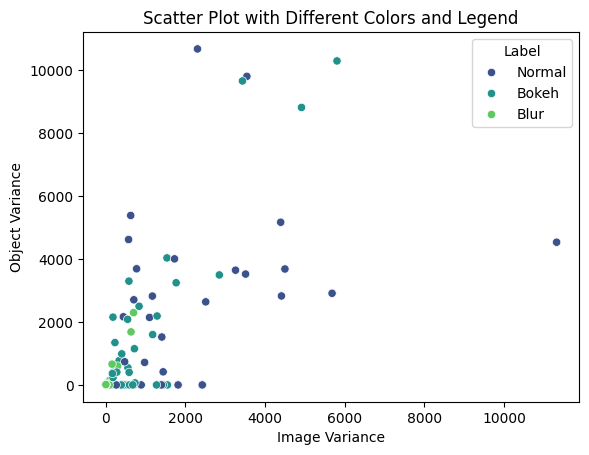

In [ ]:
plot(X_test, y_test)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

res=[]
for i, image_array in enumerate(X_test):
    image_array = image_array.numpy()
    image_array = (image_array * 255).astype(np.uint8)
    # Convert the NumPy array to RGB format if it's not already
    image_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    # Apply the Laplacian filter
    laplacian_filtered = cv2.Laplacian(gray_image, cv2.CV_16S)

    # Convert back to uint8
    laplacian_filtered = np.uint8(np.absolute(laplacian_filtered))

    # Binarize the image to create a black and white effect
    _, binary_image = cv2.threshold(laplacian_filtered, 30, 255, cv2.THRESH_BINARY)
    # _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    # plt.imshow(binary_image, cmap='gray')
    res.append([binary_image.var(),binary_image.var()])
    print(binary_image.var(), y_test[i].numpy())


7199.1431619722225 2.0
4588.361676000001 1.0
6030.085499750001 1.0
15218.808846222226 1.0
5285.223779555557 1.0
9305.554149305553 2.0
5758.983911972222 2.0
6507.452303999999 0.0
15173.982561972218 2.0
0.0 0.0
6.501849749999999 0.0
11935.378888888888 1.0
3094.539099750001 1.0
2006.0981239999996 1.0
0.0 0.0
1945.830248638889 0.0
1464.6228993055558 0.0
8846.081887888888 2.0
14250.419417749998 2.0
588.4707589999998 0.0
4277.823084 2.0
15693.44554775 2.0
0.7224919722222216 0.0
0.7224919722222218 0.0
3139.358159 1.0
3903.446503305557 2.0
3569.9446777499993 2.0
1685.7080277499997 0.0
2524.199205305556 1.0
1126.3889877500003 0.0
15362.399459555558 2.0
6923.659571555556 2.0
4941.885839 1.0
946.02350975 1.0
5005.687951555556 2.0
0.0 0.0
4365.728759888889 2.0
7.224197222222224 0.0
6341.135758222223 0.0
1305.6857437499996 0.0
11510.07344375 2.0
6988.6900866388905 2.0
5.057106638888884 0.0
0.0 0.0
0.0 0.0
7.224197222222226 0.0
2035.8464995555557 1.0
3.612299305555555 0.0
9465.25394375 2.0
5266.2222

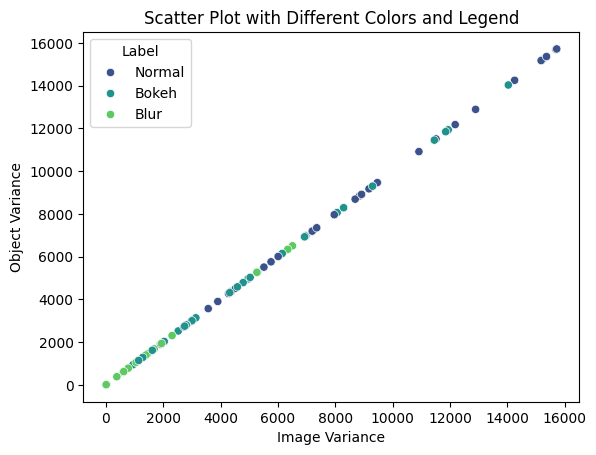

In [ ]:
plot(res,y_test)

In [ ]:
y_test[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([2., 1., 1., 1., 1., 2., 2., 0., 2., 0.], dtype=float32)>

In [ ]:
X_test.shape

TensorShape([114, 300, 300, 3])

In [ ]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=image_size,
#     batch_size=2000,
#     class_mode="sparse"
# )
# X_test, y_test = next(test_generator)
X_test_pre = FeatureExtractor(detector,image_denormalization=True)(X_test)

InvalidArgumentError: Exception encountered when calling layer 'feature_extractor_5' (type FeatureExtractor).

{{function_node __wrapped__EagerPyFunc_Tin_1_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: Input must be either real or complex. Received integer type <dtype: 'uint8'>.
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-27-469c422a3d73>", line 47, in wrapper
    object_var = self.calculate_variance_of_laplacian(object_image)

  File "<ipython-input-27-469c422a3d73>", line 84, in calculate_variance_of_laplacian
    variance = tf.math.reduce_variance(binary_image)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/weak_tensor_ops.py", line 88, in wrapper
    return op(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/math_ops.py", line 2822, in reduce_variance
    raise TypeError(f"Input must be either real or complex. "

TypeError: Input must be either real or complex. Received integer type <dtype: 'uint8'>.

 [Op:EagerPyFunc] name: 

Call arguments received by layer 'feature_extractor_5' (type FeatureExtractor):
  • inputs=tf.Tensor(shape=(114, 300, 300, 3), dtype=float32)

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
model = hub.load(module_handle)
model.signatures.keys()
detector = model.signatures["default"]

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Layer

laplacian_filter_coef_4 = tf.constant([[[[ 0]], [[-1]], [[ 0]]],
                                        [[[-1]], [[ 4]], [[-1]]],
                                        [[[ 0]], [[-1]], [[ 0]]]], dtype=tf.float32)

laplacian_filter_coef_8 = tf.constant([[[[-1]], [[-1]], [[-1]]],
                                        [[[-1]], [[ 8]], [[-1]]],
                                        [[[-1]], [[-1]], [[-1]]]], dtype=tf.float32)

class FeatureExtractor(Layer):
    def __init__(self, detector, image_denormalization=False, filter_coef=4, only_mean=True):
        super(FeatureExtractor, self).__init__()
        self.detector = detector
        self.image_denormalization = image_denormalization
        self.filter_coef = filter_coef
        self.only_mean = only_mean

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        final_result = tf.py_function(self.wrapper, [inputs], Tout=tf.float32)
        final_result.set_shape((None, final_result.shape[-1]))
        return final_result

    def wrapper(self, inputs):
        im_width, im_height = inputs.shape[1:3]

        result = []
        for image in inputs:
            image = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
            detection_result = self.detector(image)

            indices = tf.where(detection_result["detection_scores"] >= 0.25)
            detection_boxes = tf.gather(detection_result["detection_boxes"], indices)

            objects_variance = []
            for box in detection_boxes:
                ymin, xmin, ymax, xmax = box.numpy()[0]
                left, right, top, bottom = map(int, [xmin * im_width,  xmax * im_width,
                                                     ymin * im_height, ymax * im_height])

                object_image = image[0][top:bottom, left:right]
                object_var = self.calculate_variance_of_laplacian(object_image)

                objects_variance.append(object_var)

            image_variance = self.calculate_variance_of_laplacian(image)
            mean_objects_variance = tf.reduce_mean(objects_variance).numpy() if objects_variance else 0

            temp_result = [image_variance, mean_objects_variance]

            if not self.only_mean:
                temp_result.append(tf.math.reduce_max(objects_variance).numpy() if objects_variance else 0)
                temp_result.append(tf.math.reduce_min(objects_variance).numpy() if objects_variance else 0)
                temp_result.append(tf.math.reduce_variance(objects_variance).numpy() if objects_variance else 0)
                temp_result.append(tfp.stats.percentile(objects_variance, 50.0, interpolation="midpoint").numpy() if objects_variance else 0)

            result.append(temp_result)

        return tf.convert_to_tensor(result)

    def calculate_variance_of_laplacian(self, image):
        if self.image_denormalization:
            image = image * 255

        if self.filter_coef == 4:
            laplacian_filter = laplacian_filter_coef_4
        elif self.filter_coef == 8:
            laplacian_filter = laplacian_filter_coef_8

        gray_image = tf.image.rgb_to_grayscale(image)
        conv_image = tf.nn.conv2d(gray_image[tf.newaxis, ...], laplacian_filter, strides=[1, 1, 1, 1], padding="VALID")
        # conv_image = tf.squeeze(conv_image)

        # # Binarize the image to create a black and white effect
        # binary_image = tf.where(conv_image > 30, 255.0, 0.0)

        # # Convert binary_image to uint8
        # binary_image = tf.cast(binary_image, tf.uint8)
        variance = tf.math.reduce_variance(conv_image)

        return variance.numpy()

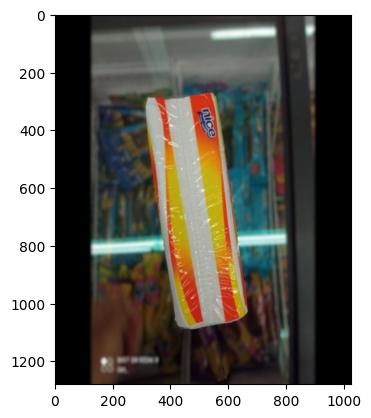

In [ ]:
plt.imshow(a[0])

In [ ]:
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(test_images)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("epoch_confusion_matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

# Start TensorBoard.
%tensorboard --logdir logs/image

# Train the classifier.
model.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=0, # Suppress chatty output
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_images, test_labels),
)
